# *Importing Required tools*



In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from sklearn import metrics

# *Splitting the train data to create validataion data*

In [ ]:
input_folder = '/content/drive/MyDrive/assignment1_data/classification_dataset/train'
output_folder = '/content/drive/MyDrive/assignment1_data/' +'split'
splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2), group_prefix=None, move = False )

# *Data transforms defined on train, val and test dataset*

In [7]:
# Transforms used to normalise the datasets and match the size with ImageNet dataset

data_transforms ={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])         
    ])
}

# *Loading train, val and test data to a dictionary*

In [8]:
test_dir = '/content/drive/MyDrive/assignment1_data/classification_dataset'

#Initially taking the train and val data into the dictionary after applying transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val']}

#Adding test data to the dictionary after applying transforms
image_datasets['test'] = datasets.ImageFolder(os.path.join(test_dir, 'test'), data_transforms['test'])

#batch_size defined as per the usage in next cells
batch_size = {'train': 4, 'val': 4, 'test': 120}

#Train and Val data is shuffled and test data is not
shuffle = {'train': 'True', 'val': 'True', 'test': 'False'}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size[x], shuffle = shuffle[x], num_workers = 2) for x in ['train', 'val','test']}
dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print('Train, Val and Test dataset after splitting and saving in the dictionary\n')
print(dataset_sizes,'\n')
print('Class Names are as follows:\n')
print(class_names)

Train, Val and Test dataset after splitting and saving in the dictionary

{'train': 423, 'val': 109, 'test': 120} 

Class Names are as follows:

['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


# *Device Information*

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.device_count()

1

In [11]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# *Finetuning the ResNet18 model*

In [13]:
#Loading the pretrained resnet18 model and freezing the gradients

model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
  param.requires_grad = False

#Modifying the last fully connected layer and adding a new linear layer with required no. of classes as output

num_features = model.fc.in_features
model.fc = nn.Linear(num_features,len(class_names))
model = model.to(device)

#Using crossentropy loss and stochastic gradient descent

criterion = torch.nn.CrossEntropyLoss()
optimizer_fc = torch.optim.SGD(model.fc.parameters(), lr = 0.01, momentum = 0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fc, step_size = 7, gamma = 0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Copying files: 44 files [06:20,  8.65s/ files]


# *Training our Model*

In [14]:
#Train model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    val_acc = []
    test_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase != 'test':
                  running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            # Storing each epoch accuracies for train, test and val data

            if phase != 'test':
              epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_acc.append(epoch_acc )
            elif phase == 'val':
              val_acc.append(epoch_acc)
            else:
              test_acc.append(epoch_acc)
            if phase != 'test':
              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
              print(f'Test accuracy for current epoch: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, test_acc

In [15]:

#Training the model(only last layer) using SGD optimizer

model, train_acc, val_acc, test_acc = train_model(model, criterion, optimizer_fc, exp_lr_scheduler, num_epochs = 25)

#Storing each epoch accuracies for train, val and test

train_acc = torch.tensor(train_acc, device = 'cpu').numpy()
val_acc = torch.tensor(val_acc, device = 'cpu').numpy()
test_acc = torch.tensor(test_acc, device = 'cpu').numpy()

Epoch 0/24
----------
train Loss: 3.0430 Acc: 0.5035
val Loss: 0.4688 Acc: 0.9358
Test accuracy for current epoch: 0.8583

Epoch 1/24
----------
train Loss: 2.5336 Acc: 0.6761
val Loss: 0.7890 Acc: 0.9083
Test accuracy for current epoch: 0.8917

Epoch 2/24
----------
train Loss: 2.0539 Acc: 0.7116
val Loss: 0.3332 Acc: 0.9541
Test accuracy for current epoch: 0.9583

Epoch 3/24
----------
train Loss: 2.5011 Acc: 0.6903
val Loss: 0.6406 Acc: 0.9266
Test accuracy for current epoch: 0.9083

Epoch 4/24
----------
train Loss: 2.9379 Acc: 0.6950
val Loss: 0.6310 Acc: 0.9266
Test accuracy for current epoch: 0.9500

Epoch 5/24
----------
train Loss: 2.9994 Acc: 0.6903
val Loss: 0.4856 Acc: 0.9358
Test accuracy for current epoch: 0.9083

Epoch 6/24
----------
train Loss: 2.9139 Acc: 0.7234
val Loss: 0.6756 Acc: 0.9083
Test accuracy for current epoch: 0.8750

Epoch 7/24
----------
train Loss: 2.3791 Acc: 0.7754
val Loss: 0.2476 Acc: 0.9633
Test accuracy for current epoch: 0.9250

Epoch 8/24
-----

# *Plotting the accuracies during training*

Text(0, 0.5, 'Accuracy')

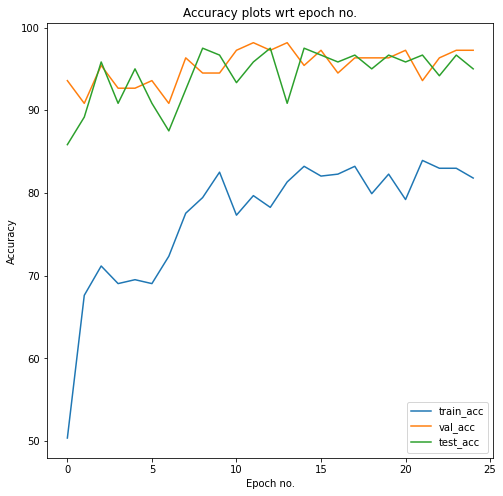

In [18]:
# Plotting accuracies

fig = plt.figure(figsize=(8, 8))
plt.plot(train_acc * 100)
plt.plot(val_acc * 100)
plt.plot(test_acc * 100)
plt.legend(['train_acc', 'val_acc', 'test_acc'])
plt.title('Accuracy plots wrt epoch no.')
plt.xlabel('Epoch no.')
plt.ylabel('Accuracy')

# *Evalutaion*

In [20]:
#Model in Evaluation mode

model.eval()
with torch.no_grad():
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
  
  predections = model(inputs)
  _, preds = torch.max(predections, 1)
  predictions = preds.cpu().numpy()
  label_list = labels.numpy()
  count = 0

# Accuracy calculation
  true_label = []
  pred_label = []
  
  for i in range(len(predictions)):
    true_label.append(class_names[label_list[i]])
    pred_label.append(class_names[predictions[i]])
    if predictions[i] == label_list[i]:
      count += 1
  print("Accuracy on Test data is: ", count * 100.0/len(label_list))
  print('\n\n\n\n                ###### CLASSIFICATION REPORT ###### \n\n')
  print(metrics.classification_report(true_label, pred_label))
  print("\n\n CONFUSION MATRIX\n\n")
  print(metrics.confusion_matrix(true_label, pred_label))

Accuracy on Test data is:  95.83333333333333




                ###### CLASSIFICATION REPORT ###### 


              precision    recall  f1-score   support

        bear       0.94      0.85      0.89        20
   butterfly       1.00      1.00      1.00        20
       camel       0.91      1.00      0.95        20
       chimp       0.91      1.00      0.95        20
        duck       1.00      1.00      1.00        20
    elephant       1.00      0.90      0.95        20

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



 CONFUSION MATRIX


[[17  0  1  2  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 20  0]
 [ 1  0  1  0  0 18]]


# *Visualiizing the model - Printing a few images with their predicted labels*

In [21]:
#Visualize the model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                #Inverting the previously applied transform so that we can view the image normally
                
                invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

                inv_tensor = invTrans(inputs.cpu().data[j])
                plt.imshow(inv_tensor.permute(1,2,0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Copying files: 58 files [10:57, 11.33s/ files]


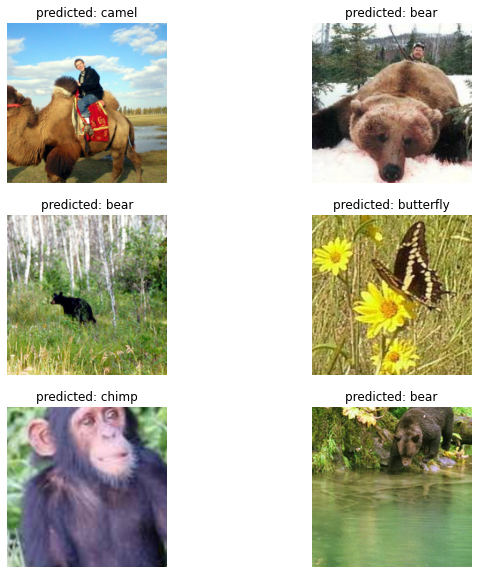

In [22]:
#Visualizing our model and printing few images with their labels

visualize_model(model)